# Convolutional Neural Networks (CNN)

En este notebook vamos a trabajar con _Convolutional Neural Networks (CNN)_ para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de _Los Simpsons_.

Como las _CNN_ profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda seguir el notebook en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si se trabaja de manera local habrá que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que se ha utilizado hasta ahora. Aparte de tener más clases (se van a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de comenzar, se recomienda descargar las imágenes y echarles un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
train_file_url = "https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60"
train_file_path = keras.utils.get_file(fname="simpsons_train.tar.gz", 
                                       origin=train_file_url,
                                       extract=True)

# Ruta de descarga de archivos
from pathlib import Path
download_dir = Path(train_file_path).parent

# Ruta del directorio de datos de entrenamiento
train_dataset_path = str(download_dir / 'simpsons')

# Hacemos lo mismo con los datos de test
test_file_url = "https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8"
test_train_path = keras.utils.get_file(fname="simpsons_test.tar.gz", 
                                       origin=test_file_url,
                                       extract=True)

# Ruta del directorio de datos de test
test_dataset_path = str(download_dir / 'simpsons_testset')

Using plaidml.keras.backend backend.


In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
            print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [5]:
# Cargamos los datos.
X_train, y_train = load_train_set(train_dataset_path, MAP_CHARACTERS, False)
X_test, y_test = load_test_set(test_dataset_path, MAP_CHARACTERS, False)

print(f'Se han cargado {X_train.shape[0]} imágenes para entrenamiento')
print(f'Se han cargado {X_test.shape[0]} imágenes para validación')

Se han cargado 18992 imágenes para entrenamiento
Se han cargado 890 imágenes para validación


## Entrenamiento y Validación de un clasificador basado en CNN

### Análisis de los datos de entrenamiento

Los datos a tratar corresponden a imágenes de personajes de los Simpsons.

Las imágenes de entrenamiento sufren una primera transformación que consiste en estandarizar sus tamaños convirtiéndolas todas en imágenes de `64x64` pixels usando OpenCV.

Una de las primeras cosas que llaman la atención al representar una imagen es que los colores no se muestran como podría esperarse (*Figure BGR*).

Esto se debe a que las imágenes se cargan por defecto en formato _BRG_ en lugar de _RGB_. Según la [documentación oficial de OpenCV](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56), `cv.imread()` admite dos parámetros de entrada, el nombre del archivo de la imagen y un segundo parámetro opcional que se trata de una cadena de flags de [opciones](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga61d9b0126a3e57d9277ac48327799c80). Este segundo argumento permite especificar en qué formato se desean cargar las imágenes.

El valor por defecto de este segundo parámetro es [`IMREAD_COLOR`](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#gga61d9b0126a3e57d9277ac48327799c80af660544735200cbe942eea09232eb822) y puede verse en el enlace que cuando este valor se especifica, hace que la imagen se carge como `BGR` en lugar de `RGB`.

Si se prueba a realizar una permutación de los canales para ajustarlos a `RGB` puede verse que la imagen ya se muestra correctamente (*Figure RGB*).

Es importante tener en cuenta que esta característica no afecta a los resultados obtenidos por la red que se va a entrenar, siempre y cuando las imágenes de entrenamiento y validación se hayan cargado de la misma manera, pues la red será entrenada para trabajar con canales `BGR` en lugar de canales `RGB`.

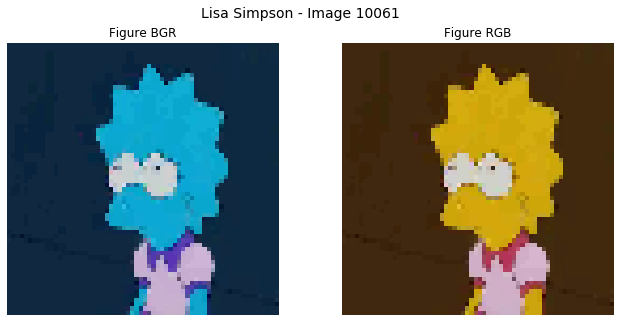

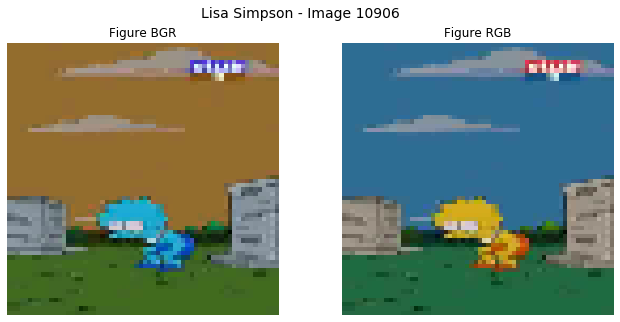

In [6]:
import matplotlib.pyplot as plt
from random import randint

def comparar_canales_imagen(indice: int):
    nombre = MAP_CHARACTERS[y_train[indice]].replace('_', ' ').title()
    imagen = X_train[indice]
    
    fig = plt.figure(figsize=(11, 5))
    fig.suptitle(f'{nombre} - Image {indice}', fontsize=14)

    ax1 = plt.subplot(1, 2, 1, aspect='equal')
    ax1.set_title('Figure BGR')
    
    ax1.imshow(imagen)
    ax1.axis('off')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1, aspect='equal')
    ax2.set_title('Figure RGB')
    ax2.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    ax2.axis('off')

    plt.show()

numero_imagenes_mostrar = 2
for x in range(0, numero_imagenes_mostrar):
    comparar_canales_imagen(indice=randint(0, X_train.shape[0]-1))

Como puede apreciarse, en la mayoría de las imágenes aparece un personaje principal en el centro de la escena que será el elemento que la red neuronal deberá identificar y ser capaz de clasificar.

### Entrenamiento del modelo

#### Preparación de los datos

Antes de poder entrenar el modelo, es necesario preparar los datos para poder trabajar con ellos:

1. Las variables categóricas, `y_train` e `y_test`, deben adaptarse para que en lugar de contener un valor único por imagen indicando la clase de la imagen, tengan un array de valores por imagen, donde todos los valores de este array serán `0` excepto el de la posición correspondiente a la clase de la imagen que será `1`.

2. Los valores de las imágenes están comprendidos en el rango `(0, 255)`, para reducir el espectro y que estos valores estén más acotados se dividen todos los valores por el máximo, `255`, y así se evita que los valores puedan encontrarse en las zonas de saturación de las funciones de coste.

3. Finalmente, los sets de entrenamiento se separan en dos subconjuntos, uno con un 80% de los datos que será usado para el entrenamiento del modelo, y el 20% restante que se usará para la validación durante el entrenamiento.

In [7]:
from sklearn.model_selection import train_test_split

# Conversión de las variables categóricas
num_classes = len(MAP_CHARACTERS)

y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

# Normalización de valores
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Generación de un conjunto de validación a partir del conjunto de entrenamiento
(X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.2)

#### Entrenamineto de la CNN

El modelo que se describe a continuación es el resultado de varias pruebas e iteraciones de distintas combinaciones de capas *fully connected*, *convolucionales*, *dropout*, *maxpooling* y *batch normalization*.

Para el modelo se ha elegido la función *ReLU* con sus valores por defecto como función de activación para todas las capas ocultad de la red y la función *SoftMax* como función de activación para la capa de salida de la red dado que lo que se quiere resolver es un problema de clasificación.

Para el entrenamiento se ha establecido un límite máximo de `100` épocas de entrenamiento, aunque como se ha usado el *callback [EarlyStopping](https://keras.io/callbacks/#earlystopping)* el entrenamiento puede parar antes de llegar a la última época si éste comienza a dar peores resultados en la métrica `loss` sobre el conjunto de validación durante una serie de épocas consecutivas.

El número de muestras por *batch* se ha fijado a `32` y se ha establecido el *learning rate* de la función de coste [*Adam*](https://keras.io/optimizers/#adam) a `1E-04`.

##### ImageDataGenerator

Para mejorar el conjunto de datos de entrenamiento se ha usado la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) que permite la obtención de nuevas imágenes a partir de realizar modificaciones sobre las imágenes de entrenamiento.

Cuando se crea este generador de imáges se pueden establecer los siguientes parámetros que indican qué modificaciones se realizarán sobre las imagénes de origen:

- `width_shift_range`: Puede recibir un número entre `0` y `1` indicando el porcentaje máximo de pixels que se puede desplazar la imagen horizontalmente. De modo que aleatoriamente una imagen puede estar desplazada entre un 0% el valor indicado, completando los extremos con la estrategia indicada por el parámetro `fill_mode`.
- `height_shift_range`: Igual que el parámetro anterior pero en este caso los desplazamientos de la imagen se realizan de manera vertical.

Estos dos parámetros facilitarían a la red poder identificar al personaje aunque éste no se encuentre totalmente centrado en la imagen.

- `rotation_range`: Admite como valor un número de grados máximos que la imagen puede ser rotada, de modo que se realizarán rotaciones aleatorias entre 0 grados y el valor especificado.
- `horizontal_flip`: Se trata de un parámetro que puede activarse o desactivarse, cuando está activo, las imágenes pueden estar reflejadas respecto de un eje vertical. Mientras que reflejar las imágenes horizontalmente tiene sentido, un personaje podría mostrarse caminando a la derecha o a la izquierda, no tiene tanto sentido realizar una reflexión vertical, dado que es bastante improbable que el personaje se encuentre invertido.
- `zoom_range`: Este valor puede ser un valor entre `0` y `1`, y se entenderá como un porcentaje que hará que la imagen se acerque o se aleje dentro del rango `[1-valor, 1+valor]`. Así pues, las imágenes generadas de este modo deberían ayudar a la red a identificar a personajes que estén más alejados en la escena y a coger rasgos más generales.
- `shear_range`: Permite establecer un ángulo de deformación de la imagen en sentido de las agujas del reloj.
- `brightness_range`: Permite modificar el brillo de la imagen dentro del rango especificado, por ejemplo `[0.7, 1.3]` permitiría obtener imágenes entre un 30% más oscuras o más claras.

En este [enlace](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) puede encontrarse una guía muy detallada sobre cómo aplican estos parámetros individualmente sobre una imagen.

Hay que tener en cuenta que cuando se entrena un red neuronal haciendo uso de *data augmentation* la función a llamar para realizar el entrenamiento es la función `fit_generator` que recibe un iterador de la clase `ImageDataGenerator` y debe especificarse el parámetro `steps_per_epoch` que típicamente se define como el número de imágenes de entrenamiento (`X_train.shape[0]`) dividido por el número de elementos por batch (`batch_size`).

Al entrenarse el modelo, se irá incrementando el iterador del generador de imágenes que irá construyendo nuevas imágenes en base a los parámetros establecidos.

El parámetro `steps_per_epoch` es necesario para indicar al generador de imágenes que ha terminado una época y va a comenzar otra, de modo que reinicie el iterador.

Lo interesante de usar `ImageDataAugmentation` con un `batch_size` y un `steps_per_epoch=X_train.shape[0]/batch_size` es que el número de imágenes usadas para entrenar es el mismo que el inicial, pero todas ellas serán siempre distintas debido a las transformaciones que el generador irá aplicando sobre ellas, con lo que se consigue reducir el efecto de memoria de la red para evitar en la medida de lo posible que ésta '*aprenda*' las imágenes.

##### Callbacks

Durante el entrenamiento del modelo se han empleado 3 clases de `Callback`:

- [`CSVLogger`](https://keras.io/callbacks/#csvlogger): para guardar la historia del entrenamiento en un fichero csv y poder recuperarla en ejecuciones posteriores.
- [`EarlyStopping`](https://keras.io/callbacks/#earlystopping): permite restablecer el mejor modelo entrenado cuando se proporciona un conjunto de validación al entrenamiento y detiene el entrenamiento si durante un número de épocas consecutivas (`patience`) la métrica a monitorizar, en este caso `val_loss`, no ha mejorado.
- [`ModelCheckpoint`](https://keras.io/callbacks/#modelcheckpoint): permite guardar en un archivo el mejor modelo entrenado para poder cargar dicho modelo en ejecuciones posteriores sin necesidad de volver a entrenar.

##### Arquitectura de la red

La red comienza con un primer bloque de capas donde se encuentran: una capa de entrada de `64x64` neuronas, seguida por una capa convolucional de 2 dimensiones, [`Conv2D`](https://keras.io/layers/convolutional/#conv2d), que cuenta con una *ventana* de `3x3`, *stride* `(1,1)` y `32` *filtros*. A continuación se especifica la función de activación, `relu`, y se aplican tres capas más: una capa [`BatchNormalization`](https://keras.io/layers/normalization/#batchnormalization) para mejorar la convergencia de la red, otra capa [`MaxPooling2D`](https://keras.io/layers/pooling/#maxpooling2d) con ventana de `2x2` para reducir la dimensionalidad de la capa y por último una capa de `Dropout` con valor `0.25` para evitar el *sobreajuste*.

A continuación se añade un segundo bloque que cuenta con una capa `Conv2D` de *ventana* `3x3` y *stride* `(1,1)` con `64` *filtros*, una función de activación `relu` y de nuevo otra capa `BatchNormalization`.

El tercer bloque está compuesto por los mismos elementos de la capa 2 y se ha añadido una capa `MaxPooling2D` para de nuevo reducir el tamaño de salida de las capas y una capa `Dropout` para reducir el *sobreajuste*.

El último bloque '*oculto*' estaría constituído por una capa [`Flatten`](https://keras.io/layers/core/#flatten) para convertir la salida de la capa anterior en una capa de dimensión 1 conectada a una capa [`Dense`](https://keras.io/layers/core/#dense) (o *fully connected*) con `1000` neuronas, función de activación `relu`, `BatchNormalization` y `Dropout`.

Finalmente la capa de salida sería una capa `Dense` con tantas neuronas como categorías a predecir disponemos y función de activación `softmax` dado que se trata de un problema de clasificación.

Las capas `Dense` se reservan para el final, dado que al ser capas totalmente conectadas requieren de un gran número de parámetros a entrenar cuando la dimensionalidad es alta. Por esto, primero se aplican las capas *convolucionales* y de `MaxPooling` que además de dar profundidad a la red reducen la dimensionalidad de las capas.

In [8]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import pandas as pd

# Parámetros del entrenamiento
epochs = 100            # Número de épocas de entrenamiento. Puede parar antes en base a EarlyStopping
batch_size = 32         # Tamaño de cada batch de entrenamiento
learning_rate = 1e-04   # Learning rate de la función de coste Adam
monitor = 'val_loss'    # Variable monitorizada durante el entrenamiento

# Habilita la opción de aumentar el número de imágenes de entrenamiento
# realizando modificaciones como rotaciones, reflexiones u otras transformaciones
# sobre las imágenes originales de entrenamiento
data_augmentation = True     

# Permite cargar un modelo previamente entrenado sin tener que volver a entrenarlo
cargar_modelo_desde_archivo = False
nombre_archivo_modelo = 'Laboratorio1-CNN.hdf5'
nombre_archivo_log_entrenamiento = 'Laboratorio1-CNN-TrainingLog.csv'

model = None     # Modelo de la CNN
history = None   # Historia del modelo entrenado

if cargar_modelo_desde_archivo:
    # Carga el modelo previamente entrenado desde un archivo
    model = load_model(nombre_archivo_modelo)
    
    # Resumen del modelo
    model.summary()
    
    # Carga la historia del modelo
    history = pd.read_csv(nombre_archivo_log_entrenamiento, sep=',')
    
else:
    # Creación del modelo secuenciasl
    model = Sequential()

    # Primer bloque
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=X_train[0].shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Segundo bloque
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Tercer bloque
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Cuarto bloque: Conversión 2D -> 1D
    model.add(Flatten())
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Capa de salida softmax
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Función de coste
    optimizer = Adam(lr=learning_rate, decay=learning_rate/epochs)

    # Compilación del modelo
    model.compile(
        optimizer=optimizer,               # Método de optimización de la función de coste
        loss='categorical_crossentropy',   # Función de coste para variables categóricas: https://keras.io/losses/
        metrics=['accuracy'])              # Métrica de evaluación durante el entrenamiento

    # Callback para registrar el progreso del entrenamiento y poder recuperar la historia sin reentrenar
    csv_logger = CSVLogger(
        nombre_archivo_log_entrenamiento,
        separator=',',
        append=False)
    
    # Callback para detener el entrenamiento si los resultados comienzan a empeorar en validación
    early_stopping = EarlyStopping(
        monitor=monitor,               # Se monitorizará la pérdida del conjunto de validación
        patience=int(epochs * 0.20),   # Número de épocas de 'empeoramiento' antes de parar
        restore_best_weights=True,     # Restaura los mejores pesos encontrados durante el entrenamiento
        verbose=True)

    # Callback para guardar en un archivo los parámetros del mejor modelo entrenado
    model_checkpoint = ModelCheckpoint(
        filepath=nombre_archivo_modelo,   # Nombre del fichero con el modelo entrenado
        monitor=monitor,                  # Variable a monitorizar para guardar el mejor entrenamiento
        save_best_only=True,              # Sólo se guarda el mejor modelo entrenado
        verbose=True)

    callbacks = [
        csv_logger,
        early_stopping,
        model_checkpoint
    ]

    # Resumen del modelo
    model.summary()

    if data_augmentation:
        # ImageDataGenerator - Data Augmentation
        # Generación de imágenes modificadas a partir de las imágenes
        # de entrenamiento para aumentar el conjunto de datos
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True)

        # Entrena el generador de imágenes
        datagen.fit(X_train)

        # Entrenamiento del modelo con generador de nuevas imágenes
        history = model.fit_generator(
            datagen.flow(X_train, y_train,
                         batch_size=batch_size),          # Genereador de imágenes
            validation_data=(X_val, y_val),               # Conjunto de validación del entrenamiento
            epochs=epochs,                                # Número de épocas del entrenamiento
            callbacks=callbacks,                          # Métodos extra ejecutados durante el entrenamiento
            steps_per_epoch=X_train.shape[0] // batch_size,
            verbose=True)
    else:
        # Entrenamiento del modelo
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=True)

INFO:plaidml:Opening device "metal_amd_radeon_hd_-_firepro_d700.1"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
__________

474/474 [==============================] - 72s 152ms/step - loss: 0.6589 - acc: 0.7985 - val_loss: 0.5701 - val_acc: 0.8326

Epoch 00024: val_loss improved from 0.58718 to 0.57012, saving model to Laboratorio1-CNN.hdf5
Epoch 25/100
474/474 [==============================] - 72s 152ms/step - loss: 0.6397 - acc: 0.8044 - val_loss: 0.5709 - val_acc: 0.8336

Epoch 00025: val_loss did not improve from 0.57012
Epoch 26/100
474/474 [==============================] - 72s 152ms/step - loss: 0.6182 - acc: 0.8144 - val_loss: 0.5557 - val_acc: 0.8376

Epoch 00026: val_loss improved from 0.57012 to 0.55570, saving model to Laboratorio1-CNN.hdf5
Epoch 27/100
474/474 [==============================] - 72s 152ms/step - loss: 0.6051 - acc: 0.8187 - val_loss: 0.5350 - val_acc: 0.8471

Epoch 00027: val_loss improved from 0.55570 to 0.53503, saving model to Laboratorio1-CNN.hdf5
Epoch 28/100
474/474 [==============================] - 72s 152ms/step - loss: 0.5939 - acc: 0.8158 - val_loss: 0.5432 - val_acc

474/474 [==============================] - 72s 151ms/step - loss: 0.2984 - acc: 0.9048 - val_loss: 0.3216 - val_acc: 0.9152

Epoch 00062: val_loss improved from 0.33102 to 0.32160, saving model to Laboratorio1-CNN.hdf5
Epoch 63/100
474/474 [==============================] - 72s 151ms/step - loss: 0.2916 - acc: 0.9103 - val_loss: 0.3564 - val_acc: 0.9016

Epoch 00063: val_loss did not improve from 0.32160
Epoch 64/100
474/474 [==============================] - 72s 151ms/step - loss: 0.2862 - acc: 0.9099 - val_loss: 0.3232 - val_acc: 0.9131

Epoch 00064: val_loss did not improve from 0.32160
Epoch 65/100
474/474 [==============================] - 72s 151ms/step - loss: 0.2869 - acc: 0.9076 - val_loss: 0.3278 - val_acc: 0.9084

Epoch 00065: val_loss did not improve from 0.32160
Epoch 66/100
474/474 [==============================] - 72s 151ms/step - loss: 0.2832 - acc: 0.9103 - val_loss: 0.3441 - val_acc: 0.9084

Epoch 00066: val_loss did not improve from 0.32160
Epoch 67/100
474/474 [===

##### Accuracy y Loss

A continuación se representan las curvas de los valores de *accuracy* y *loss* en los sets de entrenamiento y validación que se han registrado para cada época de entrenamiento.

Además se resalta cuál es la época para la que se ha obtenido el mejor resultado de `val_loss` y por tanto la época a la que corresponde el modelo entrenado.

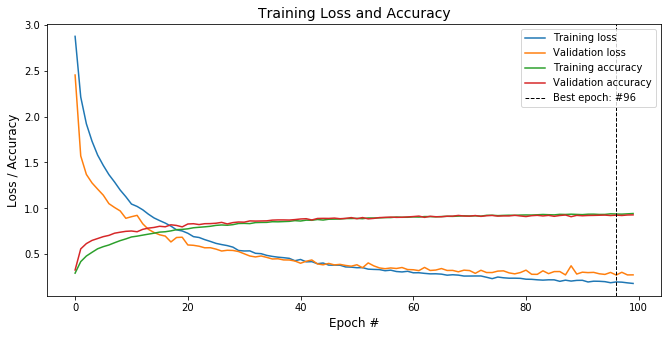

In [9]:
def representar_loss_accuracy(history, ancho_imagen:int = 11, alto_imagen:int = 5):
    if isinstance(history, keras.callbacks.History):
        history = pd.DataFrame(history.history)
        history.insert(loc=0, column='epoch', value=np.arange(0, history.shape[0]))
    
    plt.figure(figsize=(ancho_imagen, alto_imagen))
    
    plt.plot(history['epoch'], history['loss'], label="Training loss")
    plt.plot(history['epoch'], history['val_loss'], label="Validation loss")
    plt.plot(history['epoch'], history['acc'], label="Training accuracy")
    plt.plot(history['epoch'], history['val_acc'], label="Validation accuracy")
    
    best_epoch=history['val_loss'].idxmin()
    plt.axvline(x=best_epoch, label=f'Best epoch: #{best_epoch}',
                color='black', linestyle='dashed', linewidth=1)
    
    plt.title("Training Loss and Accuracy", fontsize=14)
    plt.xlabel("Epoch #", fontsize=12)
    plt.ylabel("Loss / Accuracy", fontsize=12)
    plt.legend(loc="upper right")
    
representar_loss_accuracy(history)

### Validación del modelo obtenido

Ahora se comprueba la validez del modelo entrenado en base al conjunto de datos que se ha reservado para este fin (`X_test`, `y_test`).

In [10]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)

print(f'- loss: {loss * 100:.2f}%'.format())
print(f'- accuracy: {accuracy * 100:.2f}%')

890/890 [==============================] - 2s 2ms/step
- loss: 6.18%
- accuracy: 98.43%


Como puede verse el resultado es bastante bueno y se ha conseguido un modelo con una *accuracy* de entre el 98% y el 99%.

Se prueba ahora el modelo prediciendo la clase de algunas imágenes seleccionadas aleatoriamente del conjunto de test.

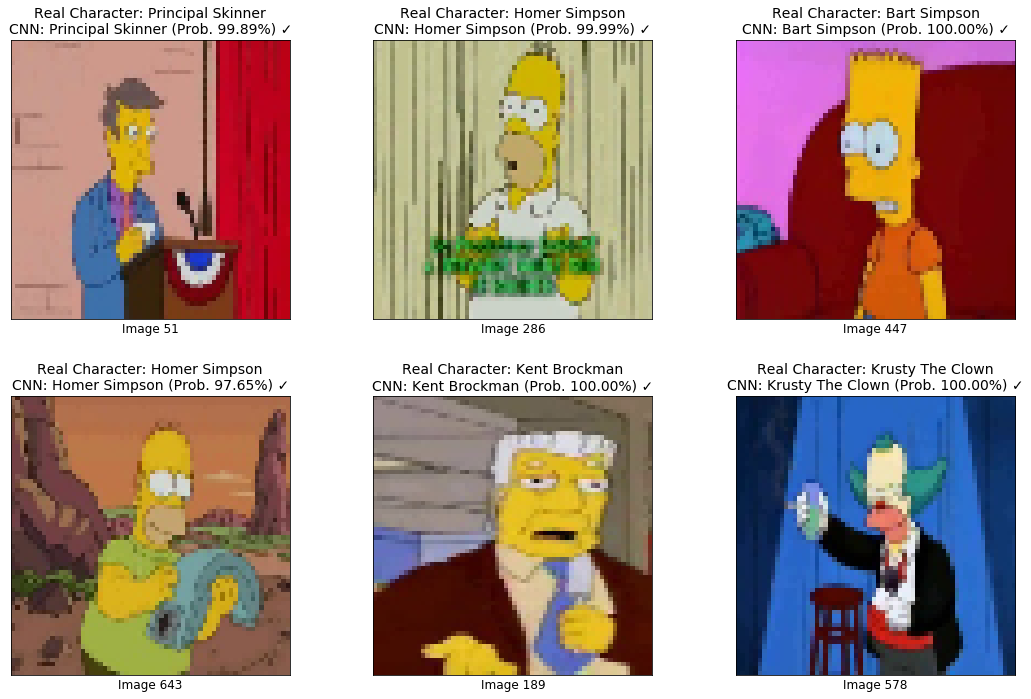

In [11]:
import math

# Predicciones a partir del conjunto de test
y_pred = model.predict(X_test, batch_size=batch_size)

# Análisis de algunos resultados
def obtener_clase(categoria: int):
    return MAP_CHARACTERS[categoria].replace('_', ' ').title()

def mostrar_imagenes(imagenes, cat_reales, cat_predichas,
                     numero_imagenes_mostrar:int = 6, numero_imagenes_fila: int = 3,
                     ancho_imagen:int = 6, alto_imagen:int = 6, aleatorio: bool = False):

    seleccion = []
    for it in range(0, numero_imagenes_mostrar):
        # Selección aleatoria de una muestra
        indice = randint(0, cat_predichas.shape[0] - 1) if aleatorio else it

        # Selección de la categoría predicha
        pred = cat_predichas[indice]   # Probabilidades de cada categoría
        cat_pred = np.argmax(pred)     # Categoría con mayor probabilidad
        prob_pred = pred[cat_pred]     # Probabilidad asociada a la categoría predicha

        # Selección de la categoría real
        cat_real = np.argmax(cat_reales[indice])

        seleccion.append({
            'indice': indice,
            'pred': cat_pred,
            'real': cat_real,
            'prob': pred[cat_pred],
            'imagen': cv2.cvtColor(imagenes[indice], cv2.COLOR_BGR2RGB)
        })

    # Representación de las muestras seleccionadas
    numero_filas = math.ceil(numero_imagenes_mostrar / numero_imagenes_fila)

    f, axes = plt.subplots(numero_filas, numero_imagenes_fila,
                           figsize=(numero_imagenes_fila * ancho_imagen,
                                    numero_filas * alto_imagen),
                           sharey=True)

    for ax, _seleccion in zip(axes.flat, seleccion):
        indice, cat_pred, cat_real, prob_pred, imagen = \
            [_seleccion[x] for x in ['indice', 'pred', 'real', 'prob', 'imagen']]

        estado = '✓' if cat_pred == cat_real else '⨯'
        title = f'Real Character: {obtener_clase(cat_real)}\n' \
            + f'CNN: {obtener_clase(cat_pred)} (Prob. {prob_pred * 100:.2f}%) {estado}'

        ax.imshow(imagen)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f'Image {indice}', fontsize=12)
    
    numero_plots = numero_filas * numero_imagenes_fila
    if numero_imagenes_mostrar < numero_plots:
        plots_borrar = numero_plots - numero_imagenes_mostrar
        for it in np.arange(0, plots_borrar):
            indice = numero_imagenes_mostrar + it
            axes.flat[indice].remove()
    
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    plt.show()

mostrar_imagenes(X_test, y_test, y_pred, aleatorio=True)

#### Casos mal etiquetados

Es interesante ver que la probabilidad con la que el modelo es capaz de predecir la clase de cada una de las imágenes es bastante alta, siendo del 100% en muchos casos (hay que tener en cuenta que este dato está truncado a dos decimales).

Ahora es interesante estudiar los casos en los que el modelo no ha sido capaz de determinar la clase correcta de las imágenes.

Se han clasificado mal 14 de 890 (1.57%)


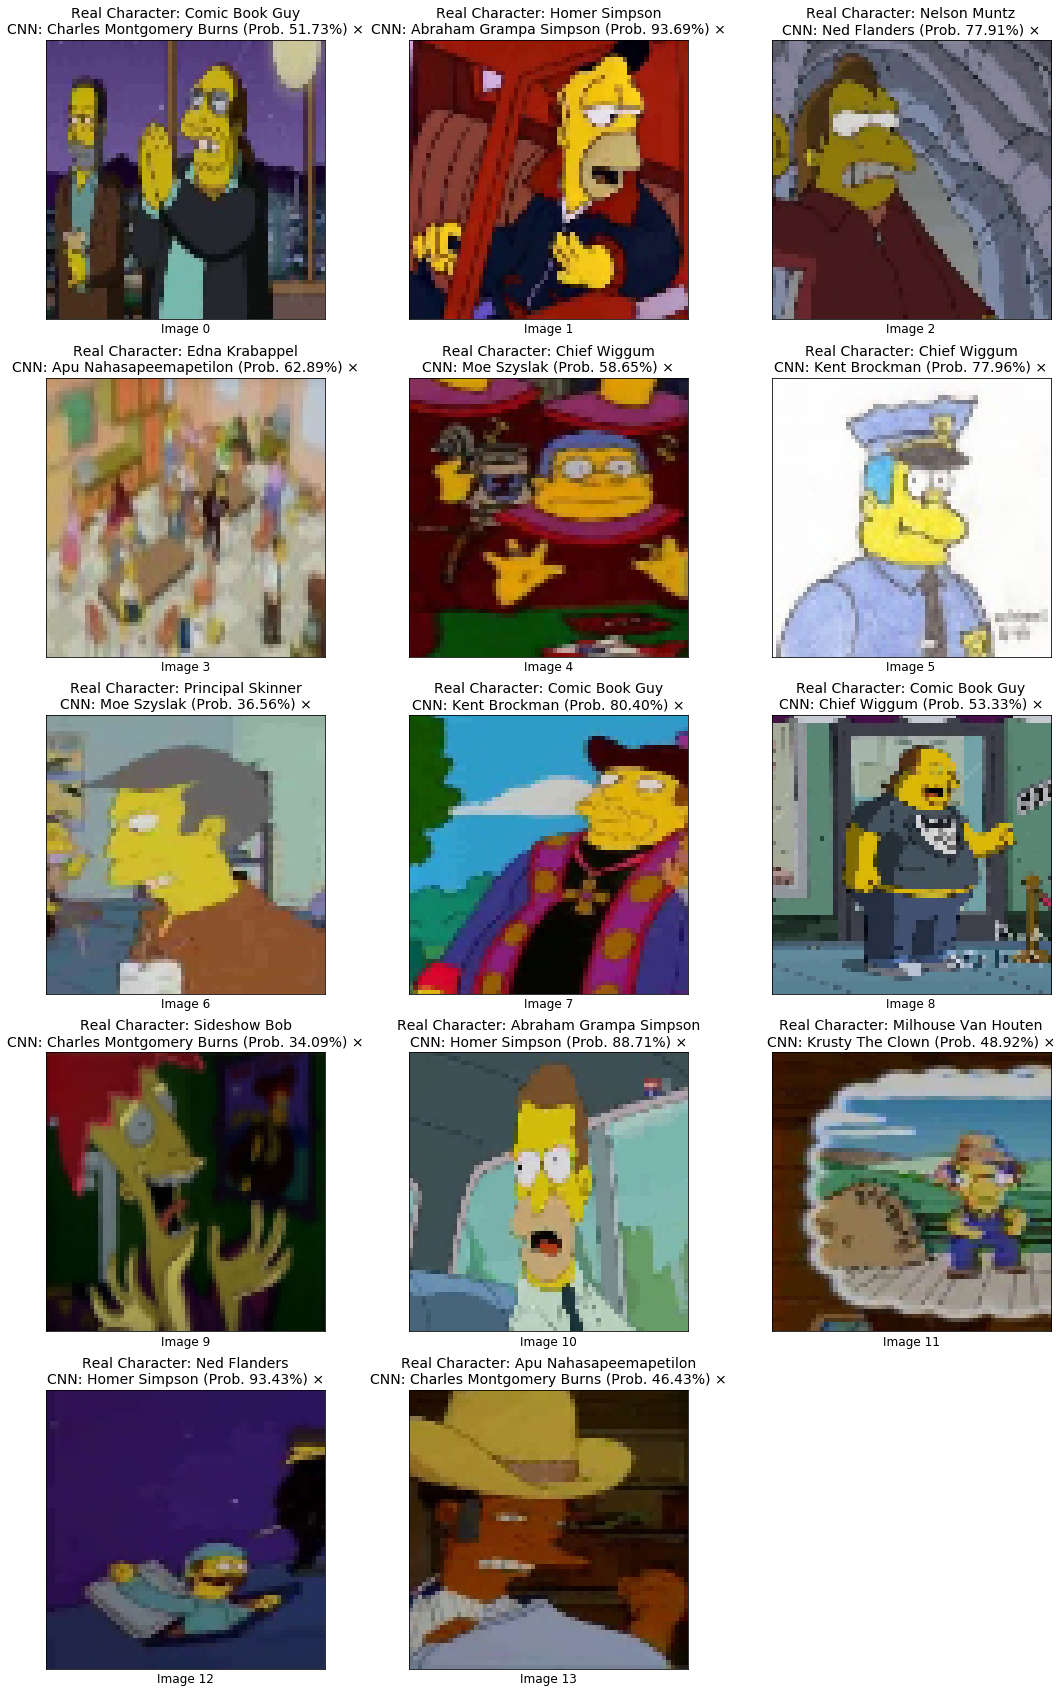

In [12]:
# Para seleccionar las imágenes que no se han etiquetado correctamente,
# primero hay que seleccionar la clase más probable de cada predicción
y_pred_cat = np.array([np.argmax(pred) for pred in y_pred])
y_test_cat = np.array([np.argmax(test) for test in y_test])

imagenes_incorrectas = y_pred_cat != y_test_cat
X_test_incorrectas = X_test[imagenes_incorrectas]
y_test_incorrectas = y_test[imagenes_incorrectas]
y_pred_incorrectas = y_pred[imagenes_incorrectas]

numero_incorrectas = np.sum(imagenes_incorrectas)
porc_error = numero_incorrectas / X_test.shape[0]
print(f'Se han clasificado mal {numero_incorrectas} de {X_test.shape[0]} ({porc_error * 100:.2f}%)')

mostrar_imagenes(X_test_incorrectas, y_test_incorrectas, y_pred_incorrectas,
                 numero_imagenes_mostrar=X_test_incorrectas.shape[0])

### Conclusiones

Como puede verse, algunas de las imágenes que no se han podido clasificar son casos bastante complicados como el de la imagen de *Edna Krabappel* en la que salen muchas personas y que el modelo no ha sido capaz de identificar.

Un dato importante a tener en cuenta es que muchas de las imágenes que se han etiquetado incorrectamente tenían un porcentaje de probabilidad bastante bajo, lo que quiere decir que la red no tenía claro que esa fuese la etiqueta correcta.

Aunque hay que reconocer que se han dado algunos casos en los que se ha obtenido un porcentaje de probabilidad superior al 80% y que no han sido correctos.

No obstante, se ha conseguido un modelo con un porcentaje muy alto de aciertos con una arquitectura bastante sencilla, lo que demuestra la capacidad de estas redes.

Además, el uso de *data augmentation* ayuda a que la red generalice mejor dado que el efecto *memoria* de la red es más débil.